In [1]:
!pip install -q pandas scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', 200)

In [2]:
from google.colab import files
uploaded = files.upload()

import io
import pandas as pd

filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

df.head()


Saving linux_auth_logs_labeled.csv to linux_auth_logs_labeled.csv


,timestamp,source_ip,server,username,service,attempts,status,port,protocol,comment,anomaly_label
0,2023-03-01T02:34:21.401236,195.241.151.7,proxy-mow-01,achang,sudo,3,Failed,22,TELNET,User achang failed login via sudo,normal
1,2024-08-14T04:53:31.834545,164.218.94.112,srv-ldn-02,www-data,sudo,4,Failed,443,RDP,User www-data failed login via sudo,normal
2,2026-11-13T23:42:42.559210,45.250.247.54,backup-prk-01,www-data,su,2,Failed,22,TELNET,User www-data failed login via su,normal
3,2025-06-21T19:38:58.716613,114.89.244.50,srv-tok-03,juancampos,login,1,Success,22,SSH2,User juancampos success login via login,normal
4,2024-03-28T19:34:14.984218,186.144.249.195,srv-tok-03,nginx,cron,3,Failed,80,NaN,User nginx failed login via cron,normal


In [3]:
# Reduce dataset to 80,000 rows to avoid RAM crash
df_small = df.sample(n=80000, random_state=42)

df_small.shape


(80000, 11)

In [4]:
df_small['log_text'] = (
    df_small['timestamp'].astype(str) + ' ' +
    df_small['source_ip'].astype(str) + ' ' +
    df_small['status'].astype(str) + ' ' +
    df_small['comment'].astype(str)
)

df_small[['log_text', 'anomaly_label']].head()


,log_text,anomaly_label
104241,2024-04-30T22:07:32.506204 205.221.230.162 Failed User root failed login via su,normal
199676,2024-07-31T08:07:31.070994 11.243.185.40 Success User admin success login via sudo,normal
140199,2023-06-03T12:07:06.295136 193.109.24.183 Failed User ec2-user failed login via sudo,normal
132814,2024-01-09T08:37:32.295319 184.219.47.115 Failed User garciajason failed login via login,normal
408697,2023-11-14T00:33:37.095792 95.158.96.29 Success User andersonsteven success login via su,normal


In [5]:
df_small['anomaly_label'] = df_small['anomaly_label'].replace({
    'normal': 0,
    'anomaly': 1,
    'malicious': 1,
    'attack': 1
})

df_small['anomaly_label'].value_counts()


,count
anomaly_label,
0,76001
privilege_escalation,1018
port_scan,1016
geo_anomaly,1015
brute_force,950


In [6]:
df_small['anomaly_label'] = df_small['anomaly_label'].replace({
    'normal': 0,
    'privilege_escalation': 1,
    'port_scan': 2,
    'geo_anomaly': 3,
    'brute_force': 4
})

df_small['anomaly_label'].value_counts()


/tmp/ipython-input-2895124480.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_small['anomaly_label'] = df_small['anomaly_label'].replace({


,count
anomaly_label,
0,76001
1,1018
2,1016
3,1015
4,950


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english'
)

X = tfidf.fit_transform(df_small['log_text'])   # KEEP SPARSE MATRIX
y = df_small['anomaly_label']

X.shape


(80000, 5000)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # keeps class balance
)

X_train.shape, X_test.shape


((64000, 5000), (16000, 5000))

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     15200
           1       1.00      1.00      1.00       204
           2       1.00      1.00      1.00       203
           3       1.00      1.00      1.00       203
           4       1.00      1.00      1.00       190

    accuracy                           1.00     16000
   macro avg       1.00      1.00      1.00     16000
weighted avg       1.00      1.00      1.00     16000



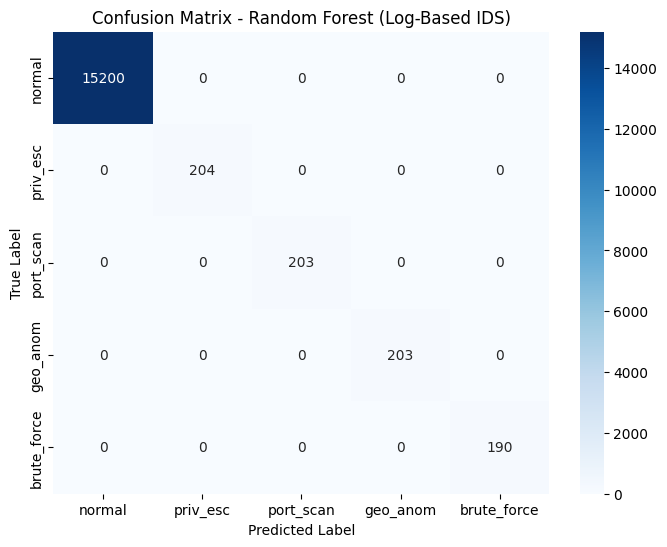

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['normal','priv_esc','port_scan','geo_anom','brute_force'],
            yticklabels=['normal','priv_esc','port_scan','geo_anom','brute_force'])

plt.title("Confusion Matrix - Random Forest (Log-Based IDS)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [12]:
sample_logs = [
    "2024-10-11 195.241.151.7 Failed User root failed login via sudo",
    "2025-02-02 10.0.0.10 Success User admin success login via ssh",
    "2024-07-21 45.12.33.19 Failed port scan detected from source_ip"
]

sample_vec = tfidf.transform(sample_logs)
pred = rf.predict(sample_vec)

pred


array([0, 0, 2])

In [13]:
label_map = {
    0: 'normal',
    1: 'privilege_escalation',
    2: 'port_scan',
    3: 'geo_anomaly',
    4: 'brute_force'
}

[label_map[i] for i in pred]


['normal', 'normal', 'port_scan']

In [14]:
import joblib

joblib.dump(rf, "log_ids_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']